In [2]:
library(edgeR)
library(magrittr)
library(ggplot2)
#library(DESeq2)
library(MAST)
library(tidyr)
library(dplyr)
library(reshape)
library(Seurat)
#library(SeuratDisk)
require(scales)
library(gplots)
library(reshape2)
library(sceasy)
library(reticulate)

In [11]:
h5ad_file <- "/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/T_NK_ILC_integration_raw_no_nan.h5ad"

sceasy::convertFormat(h5ad_file, from="anndata", to="seurat",
                      outFile='/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/T_NK_ILC_integration_raw_no_nan.rds')

X -> counts



An object of class Seurat 
33538 features across 242305 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [3]:
pseudobulk <- function(seurat_object, column, label){
    seurat_object@meta.data[,column] <- as.character(seurat_object@meta.data[,column])
    tmp <- seurat_object[,seurat_object@meta.data[,column]==label]
    tmp2 <- Matrix::rowSums(tmp@assays$RNA@counts)
    return(tmp2)
}

### column -- donor_id
### label -- each donor
### raw counts

In [4]:
sdata <- readRDS("/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/T_NK_ILC_integration_raw_no_nan.rds")

In [5]:
meta <- read.csv("/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/T_NK_ILC_integration_raw_no_nan_meta.csv")
head(meta)

,sample_id,mad_prd,Status,Site,Tissue,Enrichment,Location,Sex,Age,stage,⋯,mad_MED,mad_MAD,mad_thr,batch,integrated_sample_id,broad_cell_type,LR_pre_pre,LR_pre_post,type,Site_condition
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAGTCTGGTTGTCTTT-1-SKN8104894-Healthy,SKN8104894,False,Healthy,non_lesion,Epidermis,CD49fN_KC,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Differentiated_KC*,Differentiated_KC*,Others,Healthy_non_lesion
CTCCTAGAGCGATGAC-1-SKN8104894-Healthy,SKN8104894,False,Healthy,non_lesion,Epidermis,CD49fN_KC,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Differentiated_KC*,Differentiated_KC*,Others,Healthy_non_lesion
GCGCCAACAGGATTGG-1-SKN8104894-Healthy,SKN8104894,False,Healthy,non_lesion,Epidermis,CD49fN_KC,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Th,Th,Others,Healthy_non_lesion
AAACCTGAGAGTTGGC-1-SKN8104896-Healthy,SKN8104896,False,Healthy,non_lesion,Epidermis,Lymphocytes,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Th,Th,Others,Healthy_non_lesion
AAACCTGAGGAGTCTG-1-SKN8104896-Healthy,SKN8104896,False,Healthy,non_lesion,Epidermis,Lymphocytes,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Tc,Tc,Others,Healthy_non_lesion
AAACCTGCAACACCCG-1-SKN8104896-Healthy,SKN8104896,False,Healthy,non_lesion,Epidermis,Lymphocytes,Breast,Female,NA,adult,⋯,NA,NA,NA,NA,Healthy,T-cell,Th,Th,Others,Healthy_non_lesion


In [6]:
sdata@meta.data <- as.data.frame(meta)

In [7]:
Target_subset <- subset(sdata, cells = 
               rownames(sdata@meta.data)[which(sdata$Site_condition == 'Healthy_non_lesion' |
                                               sdata$Site_condition == 'CTCL_lesion' |
                                               sdata$Site_condition == 'AD_lesion' |
                                               sdata$Site_condition == 'Psoriasis_lesion')]) ### lesional only

In [8]:
table(Target_subset$type)


    Others tumourcell 
    184324      41831 

In [9]:
#Target_subset <- NormalizeData(Target_subset, normalization.method = "LogNormalize", scale.factor = 10000)
#Target_subset <- FindVariableFeatures(Target_subset, selection.method = "vst")

In [10]:
table(Target_subset$donor_id)


CTCL1 CTCL2 CTCL3 CTCL4 CTCL5 CTCL6 CTCL7 CTCL8    E1    E2    E3    E4    P1 
 9795  5547 13625 13538 15066 19341 58371 12155   616  2300  6506  9481  4535 
   P2    P3    S1    S2    S3    S4    S5 
 8280  5002  9528  6256  4082 12338  9793 

In [11]:
Target_subset$donor_id[which(Target_subset$type == "Others" &
                             Target_subset$Site_condition == "CTCL_lesion")] <- paste0(Target_subset$donor_id[which(Target_subset$type == "Others" &
                             Target_subset$Site_condition == "CTCL_lesion")], '_N')

In [12]:
table(Target_subset$donor_id)


  CTCL1 CTCL1_N   CTCL2 CTCL2_N   CTCL3 CTCL3_N   CTCL4 CTCL4_N   CTCL5 CTCL5_N 
   8230    1565    1900    3647    9168    4457     621   12917    7754    7312 
  CTCL6 CTCL6_N   CTCL7 CTCL7_N   CTCL8 CTCL8_N      E1      E2      E3      E4 
   3798   15543    3713   54658    6647    5508     616    2300    6506    9481 
     P1      P2      P3      S1      S2      S3      S4      S5 
   4535    8280    5002    9528    6256    4082   12338    9793 

In [13]:
mat <- c()
coln <- c()
for (name in as.vector(sort(unique(Target_subset$donor_id)))) {
     pp <- pseudobulk(Target_subset, 'donor_id', name)
     mat <- cbind(mat, pp)
     coln <- c(coln, name)
} 
colnames(mat) <- coln
rownames(mat) <- rownames(Target_subset@assays$RNA@counts)
#mat <- mat[VariableFeatures(object = Target_subset), ]
dim(mat)

[1] 33538    28

In [14]:
mat[1:5,]

,CTCL1,CTCL1_N,CTCL2,CTCL2_N,CTCL3,CTCL3_N,CTCL4,CTCL4_N,CTCL5,CTCL5_N,⋯,E3,E4,P1,P2,P3,S1,S2,S3,S4,S5
MIR1302-2HG,1,0,0,0,0,0,0,1,2,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AL627309.1,3,1,3,3,7,1,1,6,30,3,⋯,1,3,0,1,2,18,10,8,9,9
AL627309.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,1,0


In [15]:
Condition <- "tumourcell" #### Physiological conditions

control <- as.vector(unique(Target_subset$donor_id
                            [which(Target_subset$type != Condition)]))
mut <- as.vector(unique(Target_subset$donor_id
                        [which(Target_subset$type == Condition)]))
sub <- c(control, mut)
mat_sub <- mat[, sub]
groups <- factor(c(rep(1, length(control)), rep(2, length(mut))))

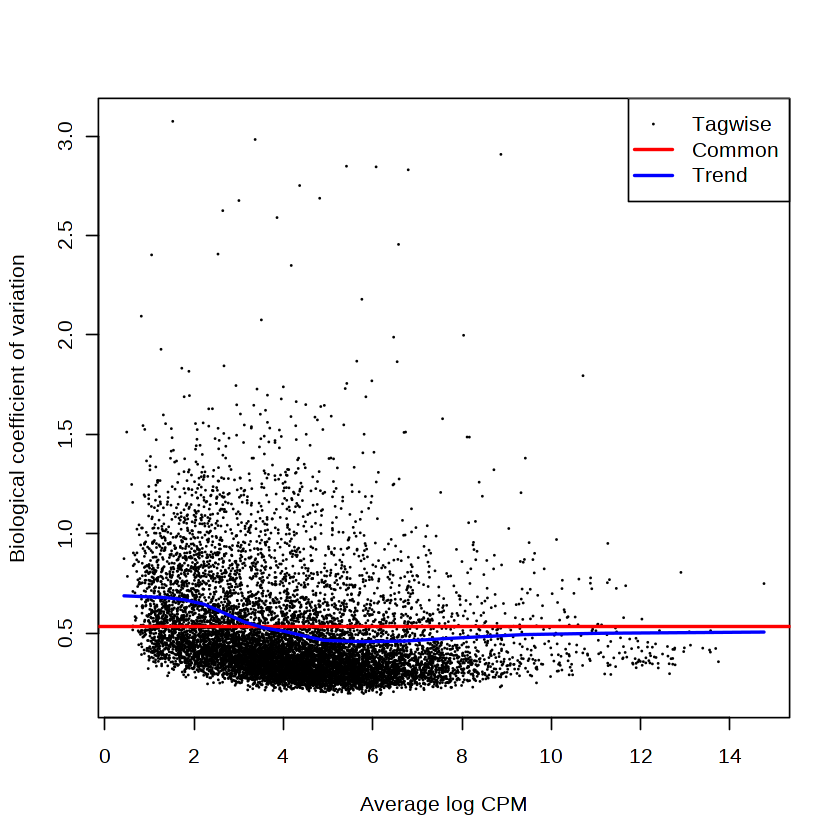

In [16]:
#########edgeR#########
DEGs <- DGEList(counts=mat_sub, group=groups)

keep <- filterByExpr(DEGs, min.count=50, min.total.count=100)
DEGs <- DEGs[keep, , keep.lib.sizes=FALSE]

DEGs <- calcNormFactors(DEGs)

#cdr <- scale(colMeans(mat_sub > 0))
#design <- model.matrix(~cdr+groups)
design <- model.matrix(~groups)

DEGs <- estimateDisp(DEGs, design = design)
fit <- glmQLFit(DEGs, design = design)
qlf <- glmQLFTest(fit,coef=2)
tt <- topTags(qlf, n = Inf)
plotBCV(DEGs)

et <- exactTest(DEGs)
et_FDR <- topTags(et, n = nrow(et$table), adjust.method = "BH", sort.by = "PValue", p.value = 1)

out_temp <- et_FDR$table

In [17]:
#out_temp
#edge_mut_up <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC>0), ]
edge_mut_down <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC<0), ]

In [18]:
edge_mut_down

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
GALNT3,-5.244137,2.9449050,6.584898e-34,7.292116e-30
LRRC32,-5.858207,2.2899970,1.850507e-25,7.415071e-22
CD300A,-6.352198,3.4534901,2.008779e-25,7.415071e-22
SH2D1B,-8.170985,2.9119624,5.963698e-24,1.651050e-20
TRAV6,-7.376568,3.0384329,7.987700e-22,1.769116e-18
CD8B,-7.497315,6.6393438,1.181409e-19,2.180488e-16
TRAV30,-7.269861,2.0786509,2.809396e-19,4.444464e-16
CD8A,-7.113077,7.2373823,5.132571e-19,7.104761e-16
BEX3,-4.802187,3.7838582,1.512087e-18,1.860539e-15


In [20]:
write.table(edge_mut_down, file='/home/jovyan/farm/CTCL/malignant_marker/Pseudobulk_down_markers_filterByExpr50_100.xls',quote=F,sep="\t")